# BTL3 môn Học Máy, mã môn học CO3117 - Học máy với dữ liệu hình ảnh
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |


## **Dataset**
Dữ liệu cho collab này bao gồm 6862 hình ảnh về thời tiết. Bao gồm 11 loại:
+ sương (gồm 698 ảnh)
+ sương mù/khói bụi (gồm 851 ảnh)
+ sương giá (gồm 475 ảnh)
+ men (gồm 639 ảnh)
+ mưa đá (gồm 591 ảnh)
+ sét (gồm 377 ảnh)
+ mưa (gồm 526 ảnh)
+ cầu vồng (gồm 232 ảnh)
+ sương muối (gồm 1160 ảnh)
+ bão cát (gồm 692 ảnh)
+ tuyết (gồm 621 ảnh)

Dữ liệu này được lấy tại [kraggle](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset).

## **Nội dung**
File collab này áp dụng pipeline học máy truyền thống cho bộ dữ liệu.

# Correct Folders

In [ ]:
%cd ..

c:\Users\ADMIN\Downloads\New folder (4)\BTL3


# Imports

In [ ]:
import os
import re
import time
import json
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler


from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# from modules.module import*
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [ ]:
!pip install transformers timm

In [ ]:
# Import transformer based image feature extractor
# We do 3 models here, Deit, Dinov2 and Swin
# Featuring different technniques
# These 3 should run fine in google collab

# Runtime :

# pre-processings
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = transforms
T = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Deit (Data-efficient Image Transformer)
# Vision Transformer with distillation token
# this has a tiny model but we will use the small one (for maybe better result)
deit_model = timm.create_model('deit_small_patch16_224', pretrained=True)
deit_model.reset_classifier(0)  # remove head for feature extraction

deit_model = deit_model.to(device).eval()
orint("Deit imported")

# Dinov2
# ViT backbone, trained self-supervised
# Pretrained weights from facebook
from transformers import AutoImageProcessor, AutoModel
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small")

dinov2_model = dinov2_vits14(pretrained=True).to(device).eval()

# Swin tiny
# Windowed attention
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
swin_model.reset_classifier(0)
swin_model = swin_model.to(device).eval()

# Fetching data

In [ ]:
img_shape= (300,300,3)  # Kích thước ảnh đầu vào

In [ ]:
import kagglehub
data_path=kagglehub.dataset_download(handle="jehanbhathena/weather-dataset")+"/dataset"

In [ ]:
os.listdir(data_path)

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

# Preprocessing

In [ ]:
image_info = []

for label in os.listdir(data_path):
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        h, w, c = img.shape
        image_info.append({
            "label": label,
            "width": w,
            "height": h,
            "channels": c,
            "url": img_path
        })

In [ ]:
df = pd.DataFrame(image_info)
df.head()

label  width  height  channels  \
0   dew    950     675         3   
1   dew    871     578         3   
2   dew    806     564         3   
3   dew   1200     797         3   
4   dew    947     592         3   

                                                 url  
0  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
1  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
2  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
3  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...  
4  C:\Users\ADMIN\.cache\kagglehub\datasets\jehan...

In [ ]:
print(df.describe())              # Thống kê cơ bản
print(df["channels"].value_counts())  # RGB hay grayscale

             width       height  channels
count  6862.000000  6862.000000    6862.0
mean    520.029729   373.841737       3.0
std     352.023100   251.419153       0.0
min     117.000000    91.000000       3.0
25%     400.000000   255.000000       3.0
50%     400.000000   280.000000       3.0
75%     500.000000   400.000000       3.0
max    4863.000000  3174.000000       3.0
channels
3    6862
Name: count, dtype: int64


label
rime         1160
fogsmog       851
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: count, dtype: int64


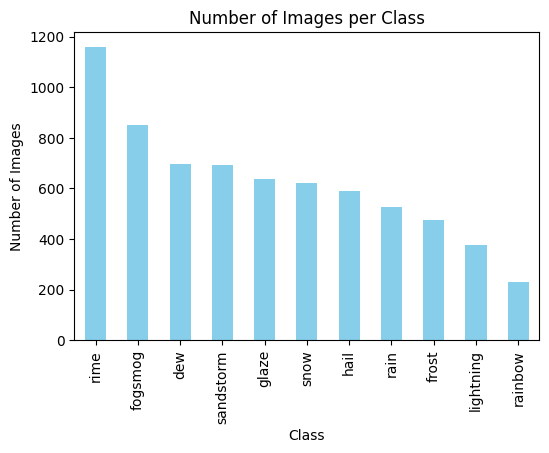

In [ ]:
label_counts = df["label"].value_counts()
print(label_counts)
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

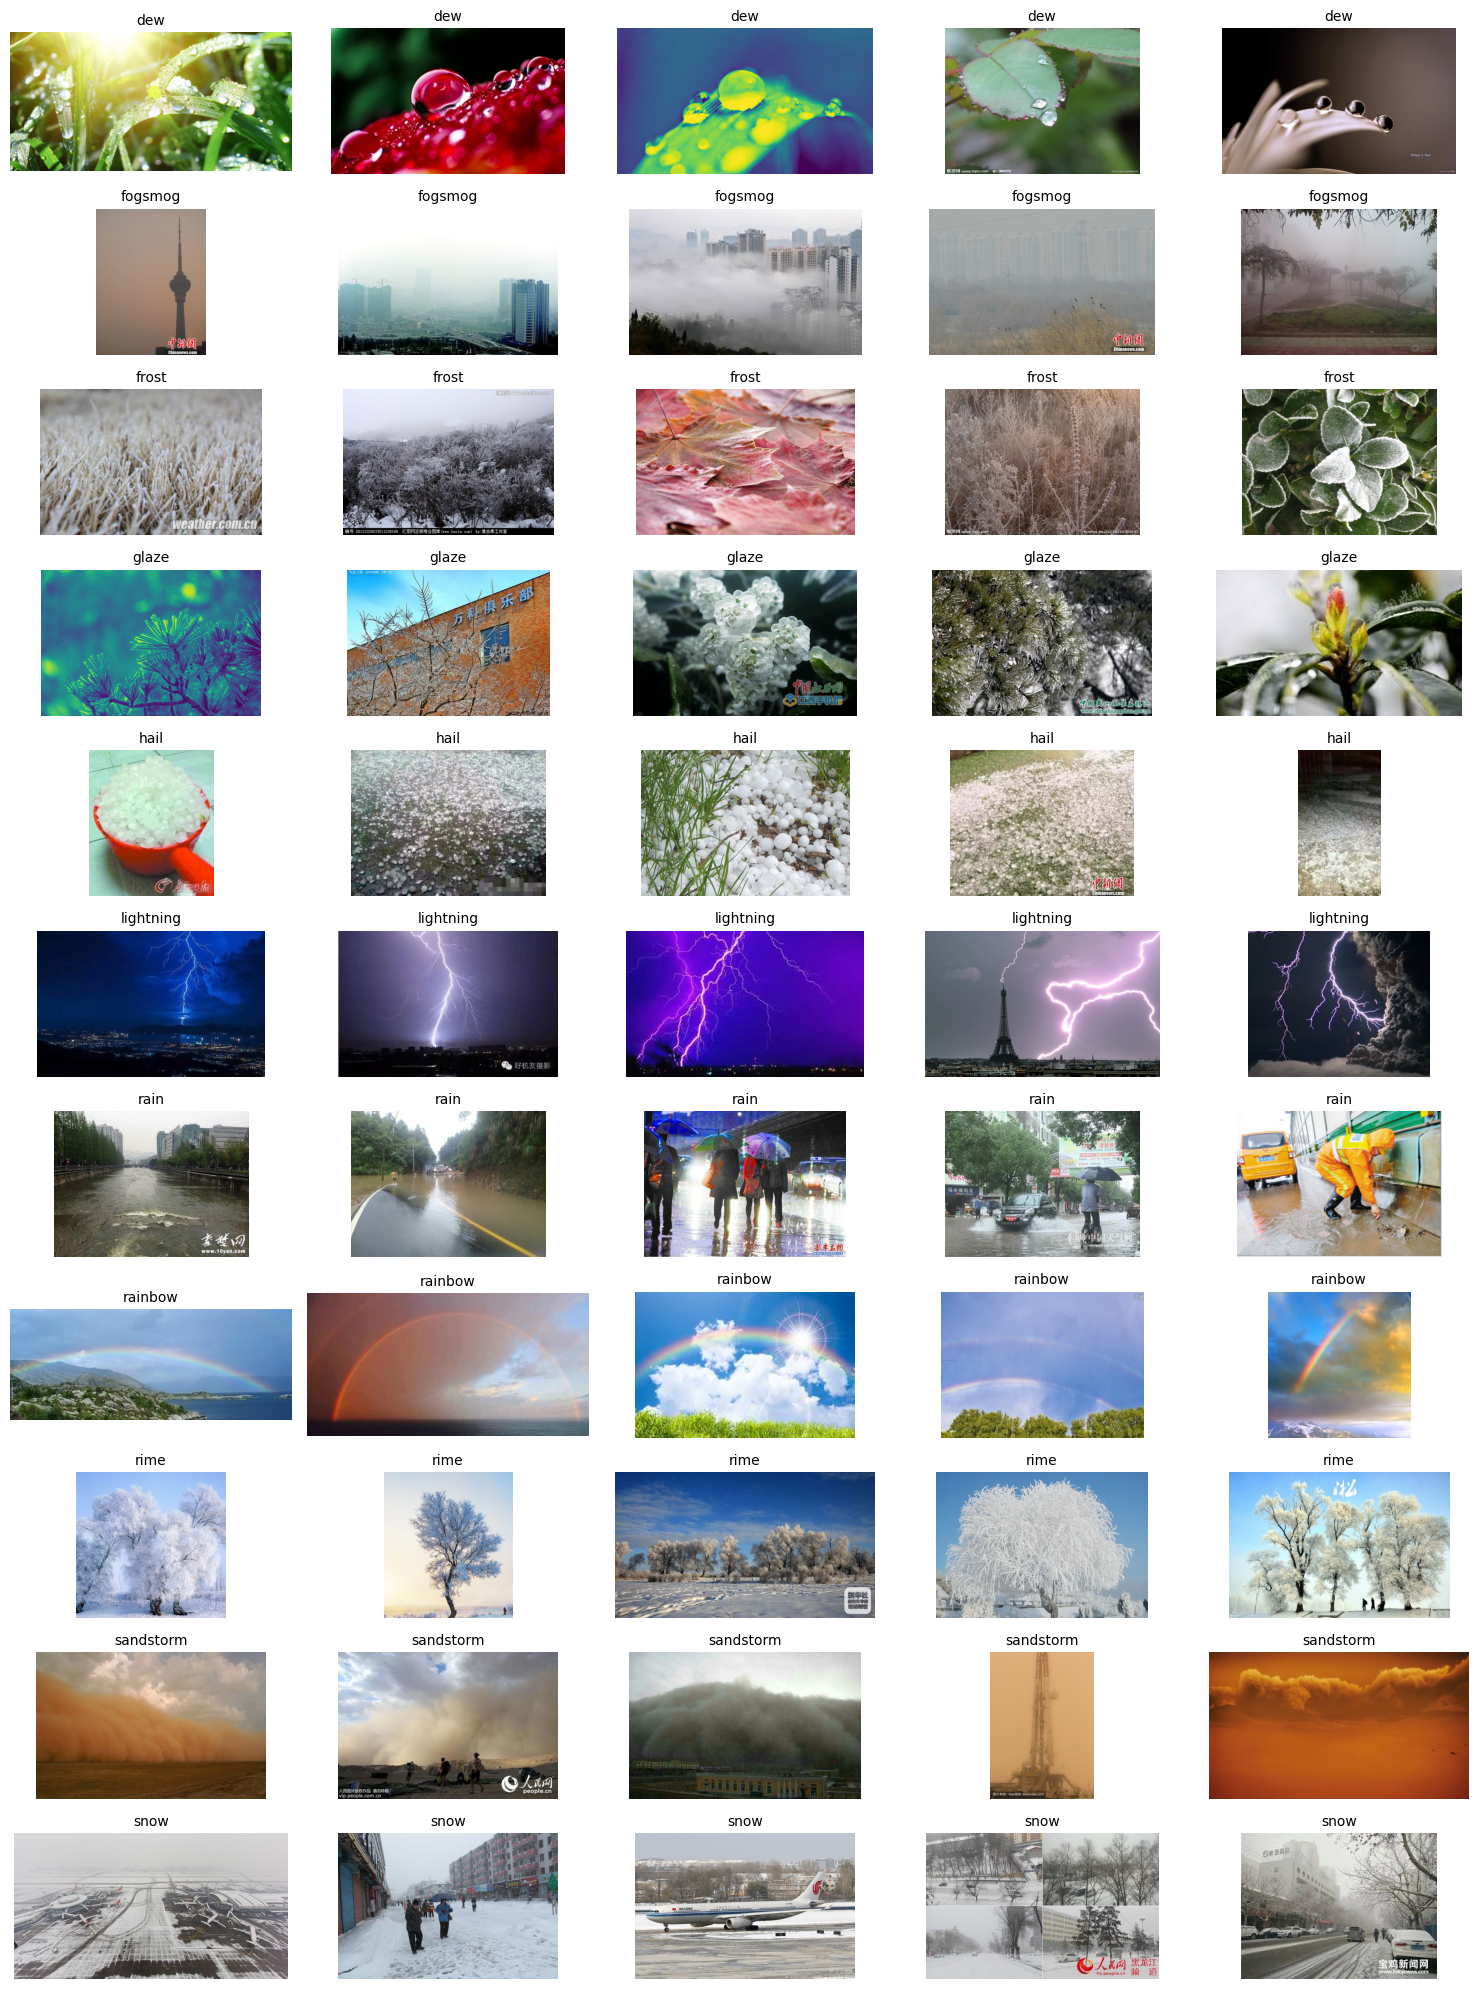

In [ ]:

num_samples = 5
plt.figure(figsize=(15, 20))

for class_idx, label in enumerate(df["label"].unique()):
    sample_images = df[df["label"] == label].sample(n=num_samples)
    for i, row in enumerate(sample_images.itertuples()):
        img = plt.imread(row.url)
        ax = plt.subplot(len(df["label"].unique()), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"{row.label}", fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

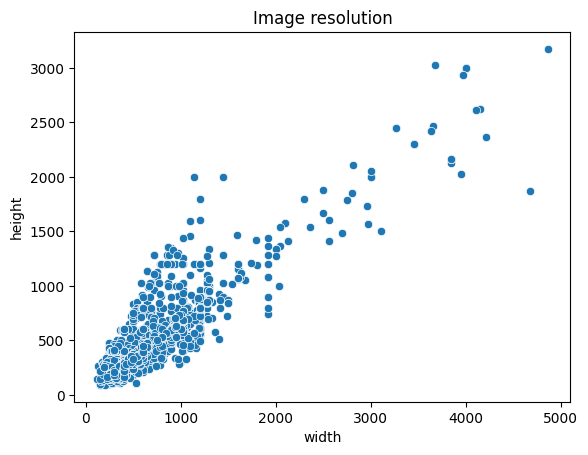

In [ ]:
sns.scatterplot(x = "width", y = "height", data = df)
plt.title("Image resolution")

plt.xlabel("width")
plt.ylabel("height")

plt.show()

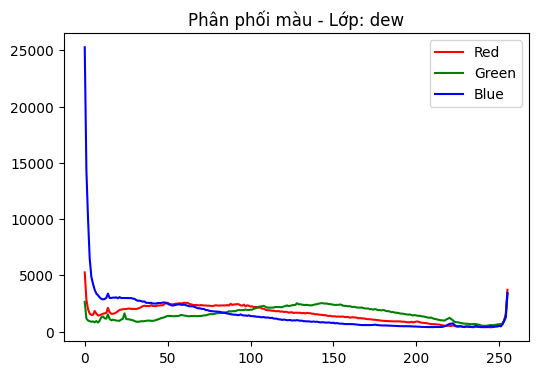

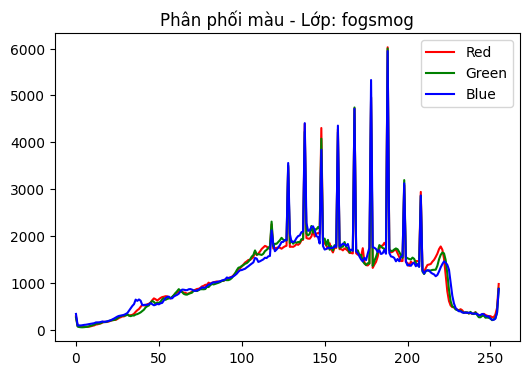

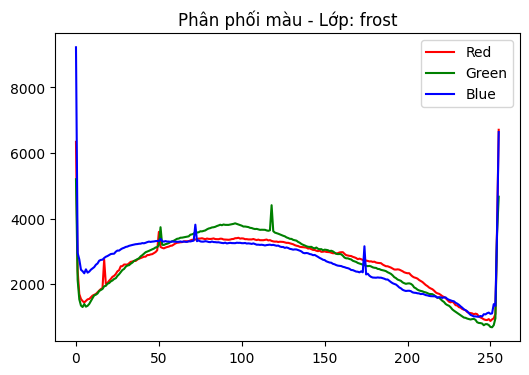

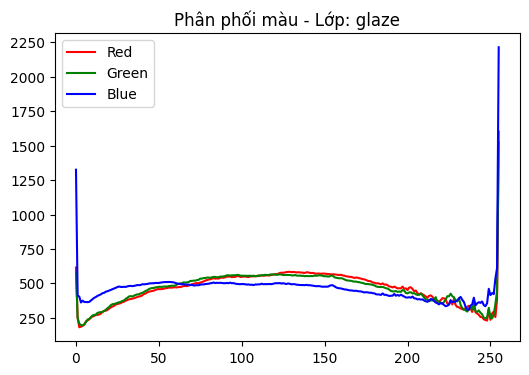

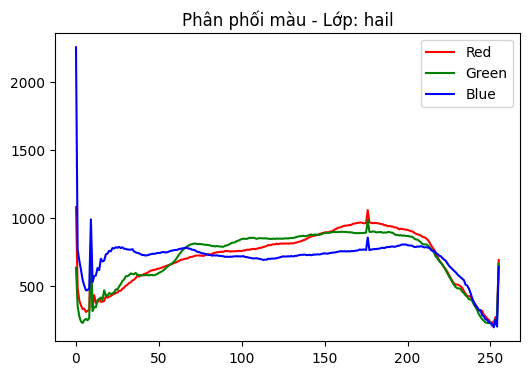

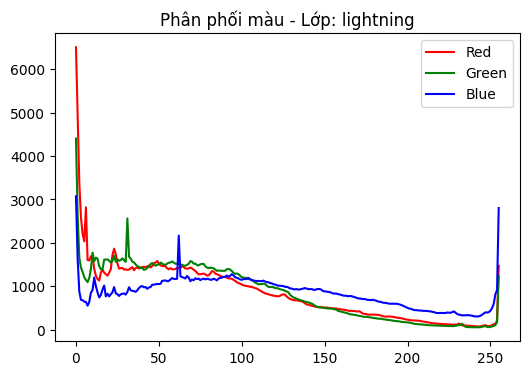

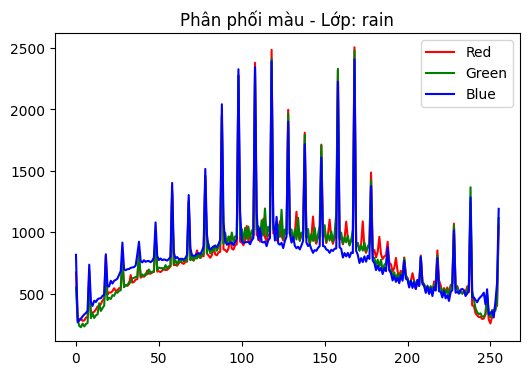

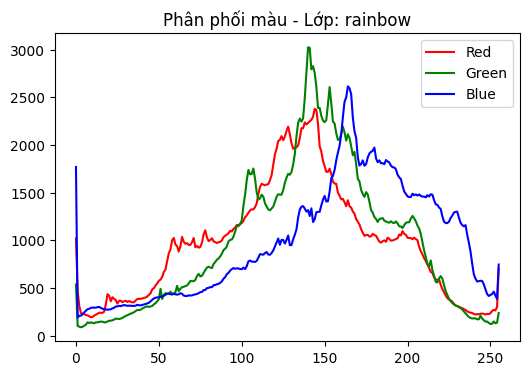

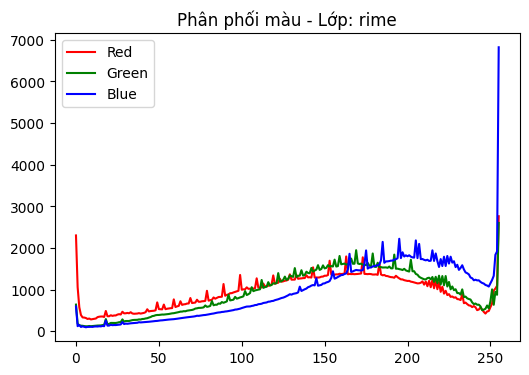

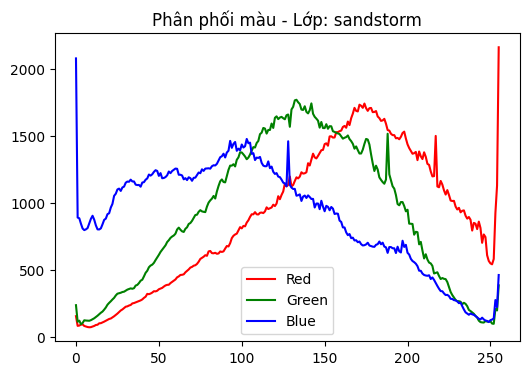

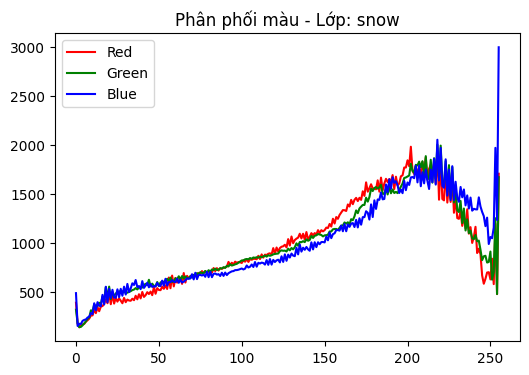

In [ ]:


# Danh sách lớp (mỗi thư mục con là 1 lớp)
classes = os.listdir(data_path)

# Lưu histogram trung bình của mỗi lớp
hist_by_class = {cls: {'b': None, 'g': None, 'r': None} for cls in classes}

# Duyệt từng lớp
for cls in classes:
    class_path = os.path.join(data_path, cls)
    b_hist_list, g_hist_list, r_hist_list = [], [], []

    # Duyệt từng ảnh trong lớp
    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Tính histogram cho từng kênh
        b_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        g_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
        r_hist = cv2.calcHist([img], [2], None, [256], [0, 256])

        b_hist_list.append(b_hist)
        g_hist_list.append(g_hist)
        r_hist_list.append(r_hist)

    # Trung bình histogram trong lớp
    hist_by_class[cls]['b'] = np.mean(b_hist_list, axis=0)
    hist_by_class[cls]['g'] = np.mean(g_hist_list, axis=0)
    hist_by_class[cls]['r'] = np.mean(r_hist_list, axis=0)

# Vẽ biểu đồ
for cls in classes:
    plt.figure(figsize=(6,4))
    plt.title(f'Phân phối màu - Lớp: {cls}')
    plt.plot(hist_by_class[cls]['r'], color='r', label='Red')
    plt.plot(hist_by_class[cls]['g'], color='g', label='Green')
    plt.plot(hist_by_class[cls]['b'], color='b', label='Blue')
    plt.legend()
    plt.show()

# Feature extraction

In [ ]:
model = EfficientNetB3(include_top= False,
                       weights= "imagenet",
                       input_shape= img_shape,
                       pooling= 'max')
def extract_features(img_path, target_size=(300, 300)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = np.array(img, dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

43941136/43941136 [==============================] - 14s 0us/step


In [ ]:

features_list, labels = [], []
for label in os.listdir(data_path):
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        continue
    print(f"📂 Đang xử lý lớp: {label}")
    for file in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, file)
        try:
            feat = extract_features(img_path)
            features_list.append(feat)
            labels.append(label)
        except Exception as e:
            print("Lỗi khi xử lý", file, ":", e)

📂 Đang xử lý lớp: dew


100%|██████████| 698/698 [01:29<00:00,  7.81it/s]


📂 Đang xử lý lớp: fogsmog


100%|██████████| 851/851 [02:01<00:00,  7.01it/s]


📂 Đang xử lý lớp: frost


100%|██████████| 475/475 [01:10<00:00,  6.73it/s]


📂 Đang xử lý lớp: glaze


100%|██████████| 639/639 [01:28<00:00,  7.23it/s]


📂 Đang xử lý lớp: hail


100%|██████████| 591/591 [01:22<00:00,  7.12it/s]


📂 Đang xử lý lớp: lightning


100%|██████████| 377/377 [00:58<00:00,  6.49it/s]


📂 Đang xử lý lớp: rain


100%|██████████| 526/526 [01:12<00:00,  7.22it/s]


📂 Đang xử lý lớp: rainbow


100%|██████████| 232/232 [00:32<00:00,  7.16it/s]


📂 Đang xử lý lớp: rime


100%|██████████| 1160/1160 [02:42<00:00,  7.12it/s]


📂 Đang xử lý lớp: sandstorm


100%|██████████| 692/692 [01:32<00:00,  7.48it/s]


📂 Đang xử lý lớp: snow


100%|██████████| 621/621 [01:20<00:00,  7.68it/s]


# Saving features

In [ ]:
features_array = np.array(features_list)
labels_array = np.array(labels)
np.save("features/efficientnet.npy", features_array)
np.save("features/label.npy", labels_array)

NameError: name 'features_list' is not defined

# Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
def report(all_preds,all_labels,label_encoding=None):
    cm = confusion_matrix(all_labels, all_preds)
    classes = label_encoding.classes_ if label_encoding is not None else np.unique(all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

In [ ]:
models_list = {
    "SVM":LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000), #2m
    "Random Forest Regressor, n=50": RandomForestClassifier(n_estimators=50, random_state=42), #30s
    "Random Forest Regressor, n=100": RandomForestClassifier(n_estimators=100, random_state=42), #1m
}

In [ ]:
data=np.load('features/efficientnet.npy')
label=np.load('features/label.npy',allow_pickle=True)
# label_encoding=LabelEncoder()
# label=label_encoding.fit_transform(label)

Training SVM


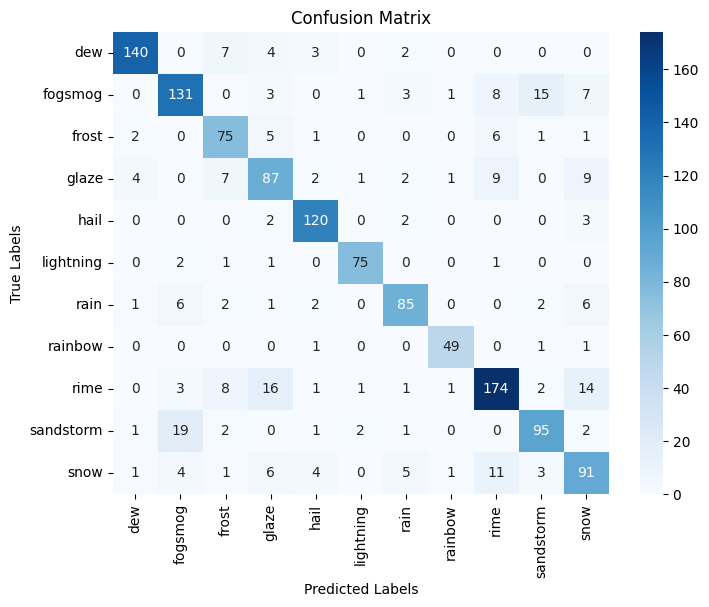


 Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.90      0.92       156
     fogsmog       0.79      0.78      0.78       169
       frost       0.73      0.82      0.77        91
       glaze       0.70      0.71      0.70       122
        hail       0.89      0.94      0.92       127
   lightning       0.94      0.94      0.94        80
        rain       0.84      0.81      0.83       105
     rainbow       0.92      0.94      0.93        52
        rime       0.83      0.79      0.81       221
   sandstorm       0.80      0.77      0.79       123
        snow       0.68      0.72      0.70       127

    accuracy                           0.82      1373
   macro avg       0.82      0.83      0.83      1373
weighted avg       0.82      0.82      0.82      1373

Training Logistic Regression


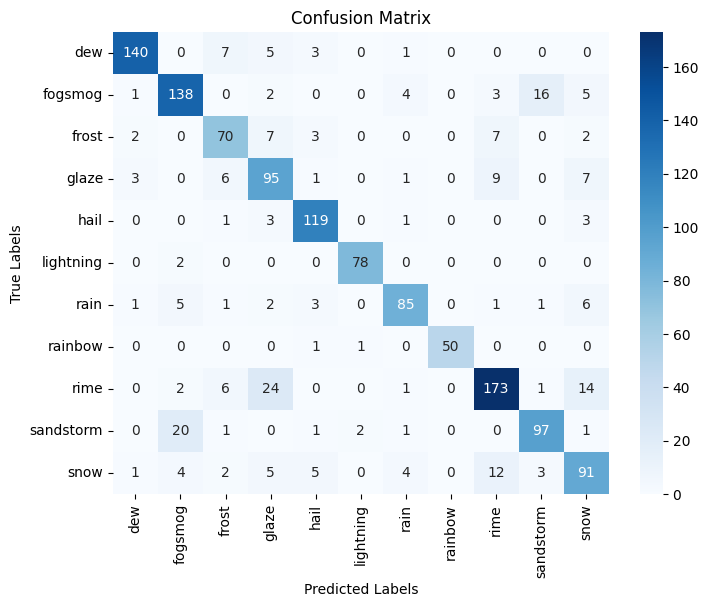


 Classification Report:

              precision    recall  f1-score   support

         dew       0.95      0.90      0.92       156
     fogsmog       0.81      0.82      0.81       169
       frost       0.74      0.77      0.76        91
       glaze       0.66      0.78      0.72       122
        hail       0.88      0.94      0.90       127
   lightning       0.96      0.97      0.97        80
        rain       0.87      0.81      0.84       105
     rainbow       1.00      0.96      0.98        52
        rime       0.84      0.78      0.81       221
   sandstorm       0.82      0.79      0.80       123
        snow       0.71      0.72      0.71       127

    accuracy                           0.83      1373
   macro avg       0.84      0.84      0.84      1373
weighted avg       0.83      0.83      0.83      1373

Training Random Forest Regressor, n=50


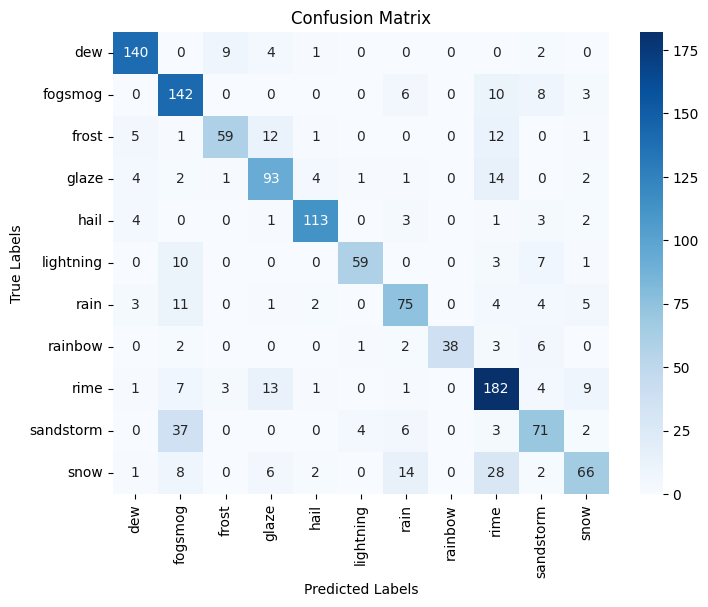


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.90      0.89       156
     fogsmog       0.65      0.84      0.73       169
       frost       0.82      0.65      0.72        91
       glaze       0.72      0.76      0.74       122
        hail       0.91      0.89      0.90       127
   lightning       0.91      0.74      0.81        80
        rain       0.69      0.71      0.70       105
     rainbow       1.00      0.73      0.84        52
        rime       0.70      0.82      0.76       221
   sandstorm       0.66      0.58      0.62       123
        snow       0.73      0.52      0.61       127

    accuracy                           0.76      1373
   macro avg       0.79      0.74      0.76      1373
weighted avg       0.77      0.76      0.75      1373

Training Random Forest Regressor, n=100


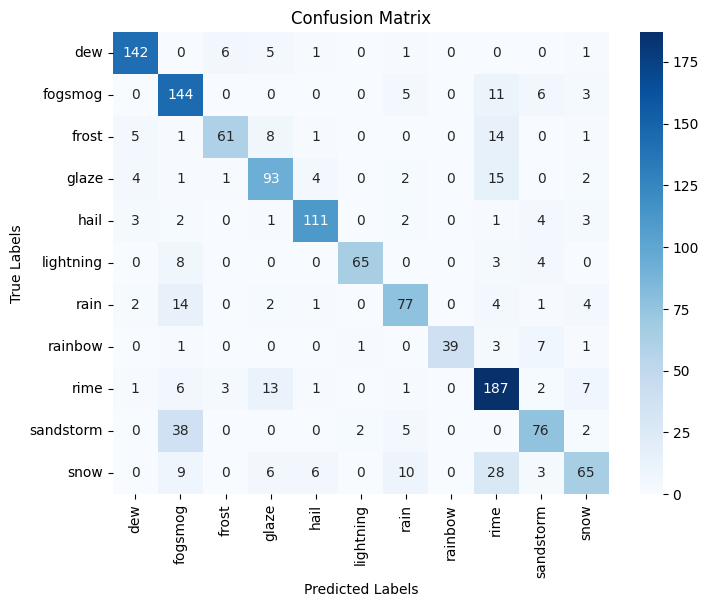


 Classification Report:

              precision    recall  f1-score   support

         dew       0.90      0.91      0.91       156
     fogsmog       0.64      0.85      0.73       169
       frost       0.86      0.67      0.75        91
       glaze       0.73      0.76      0.74       122
        hail       0.89      0.87      0.88       127
   lightning       0.96      0.81      0.88        80
        rain       0.75      0.73      0.74       105
     rainbow       1.00      0.75      0.86        52
        rime       0.70      0.85      0.77       221
   sandstorm       0.74      0.62      0.67       123
        snow       0.73      0.51      0.60       127

    accuracy                           0.77      1373
   macro avg       0.81      0.76      0.78      1373
weighted avg       0.78      0.77      0.77      1373



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
for name, model in models_list.items():
    print("Training "+ name)
    model.fit(X_train, y_train)
    all_preds = model.predict(X_test)
    all_labels = y_test
    report(all_preds,all_labels,None)